Домашняя работа
Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
При агрегации (pandas.DataFrame.groupby) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

общая сумма транзакций по каждой из trx_category
общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
Обязательная часть: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
Дополнительная часть: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Метрика оценки качества - ROC AUC(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
Задания принимаются в виде ноутбука с кодов/картинками выполненной обязательной части

In [110]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import datetime
import seaborn as sns

In [107]:
df = pd.read_csv('rosbank_train.csv')
del df['target_sum']
df.head(5)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0


In [84]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 9 columns):
PERIOD          490513 non-null object
cl_id           490513 non-null int64
MCC             490513 non-null int64
channel_type    487603 non-null object
currency        490513 non-null int64
TRDATETIME      490513 non-null object
amount          490513 non-null float64
trx_category    490513 non-null object
target_flag     490513 non-null int64
dtypes: float64(1), int64(4), object(4)
memory usage: 33.7+ MB


In [7]:
df.describe()

,cl_id,MCC,currency,amount,target_flag
count,490513.000000,490513.000000,490513.000000,4.905130e+05,490513.000000
mean,4802.127361,5699.783822,810.601854,5.723594e+03,0.652588
std,2986.492835,662.933380,38.223123,7.703763e+04,0.476148
min,0.000000,742.000000,32.000000,4.000000e-02,0.000000
25%,2193.000000,5411.000000,810.000000,2.240000e+02,0.000000
50%,4576.000000,5661.000000,810.000000,6.240000e+02,1.000000
75%,7390.000000,5941.000000,810.000000,2.176000e+03,1.000000
max,10215.000000,9405.000000,986.000000,3.583500e+07,1.000000


In [32]:
#количество уникальных клиентов
df['cl_id'].nunique()


5000

In [31]:
#
df['MCC'].nunique()

344

In [108]:

df['Hour'] = df.TRDATETIME.str[8:10]
df['Hour'].value_counts()
#Стало понятно, что время точное время по многим операциям не проставлено

00    432913
13      4843
12      4707
11      4681
14      4397
15      4120
10      4088
16      3848
17      3816
18      3659
09      3635
19      2704
08      2699
07      1983
20      1797
06      1315
21      1268
05       981
22       850
04       660
23       491
03       456
02       350
01       252
Name: Hour, dtype: int64

In [111]:
def add_day_col(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    return dataset

In [113]:
add_day_col(df)

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,Hour,day_of_transaction
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.00,POS,0,00,6
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.00,DEPOSIT,0,12,4
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.00,POS,0,00,2
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.00,POS,0,00,6
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.00,C2C_OUT,0,13,2
5,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,380.00,POS,0,00,1
6,01/10/2017,1,5814,NaN,810,10OCT17:00:00:00,378.00,POS,0,00,2
7,01/10/2017,1,5814,NaN,810,16OCT17:00:00:00,199.00,POS,0,00,1
8,01/10/2017,1,5814,NaN,810,11OCT17:00:00:00,400.00,POS,0,00,3
9,01/07/2017,1,5411,NaN,810,26JUL17:00:00:00,598.00,POS,0,00,3


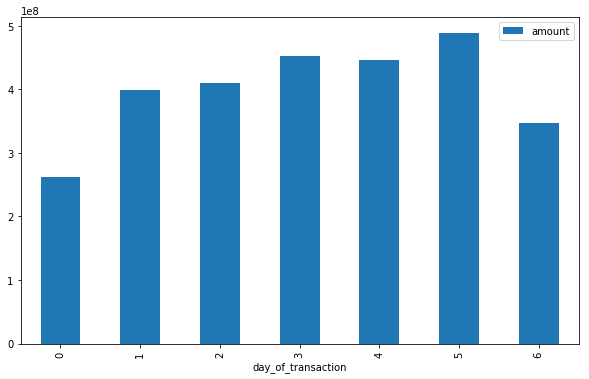

In [30]:
def transaction_by_day_count(dataset):
    dataset['day_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%w')
    ) 
    tmp_df = dataset.groupby(
        ['cl_id','day_of_transaction']
    )['day_of_transaction'].size().unstack().fillna(0).reset_index()
    old_columns = [
        old_col for old_col in tmp_df.columns.tolist()
        if old_col in dataset['day_of_transaction'].unique()
    ]
    tmp_df.rename(
        columns={old_col: 'day_' + old_col for old_col in old_columns},
        inplace=True
    )
    return tmp_df
    
    

def transaction_by_hour_count(dataset):
    dataset['hour_of_transaction'] = dataset['TRDATETIME'].apply(
        lambda x: (datetime.datetime.strptime(x, '%d%b%y:%H:%M:%S')).strftime('%H')
    ) 
    return dataset.groupby(
        ['cl_id','hour_of_transaction']
    )['hour_of_transaction'].size().unstack().fillna(0).reset_index()

transaction_by_day_count(df).

day_of_transaction,cl_id,day_0,day_1,day_2,day_3,day_4,day_5,day_6
0,0,0.0,0.0,2.0,0.0,1.0,0.0,2.0
1,1,7.0,20.0,20.0,16.0,16.0,10.0,15.0
2,5,15.0,19.0,19.0,15.0,25.0,24.0,25.0
3,9,5.0,8.0,7.0,5.0,6.0,4.0,4.0
4,10,74.0,35.0,62.0,68.0,65.0,57.0,102.0
5,11,28.0,29.0,30.0,25.0,40.0,40.0,25.0
6,14,14.0,22.0,12.0,15.0,30.0,39.0,4.0
7,20,6.0,10.0,15.0,13.0,22.0,7.0,4.0
8,21,22.0,6.0,13.0,18.0,16.0,36.0,13.0
9,22,15.0,6.0,0.0,1.0,12.0,11.0,14.0


In [121]:
# заменем отсутствующие значения в столбце 'канал привлечения' на 'type6'
df['channel_type'].fillna('type6', inplace=True)
df['channel_type'].value_counts(dropna=False)

type1    299247
type2    175013
type5      5587
type4      4476
type3      3280
type6      2910
Name: channel_type, dtype: int64

In [100]:
#Заменяем коды МСС
codes = pd.read_excel('mcc_codes.xls',header=1)
del codes['Unnamed: 2']
df = df.merge(codes, left_on='MCC',right_on='MCC CODE',how = 'left')
df.drop('MCC CODE',axis = 1, inplace = True)
df.head()


,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,Hour,Program Type:
0,01/10/2017,0,5200,NaN,810,2017-10-21 00:00:00,5023.0,POS,0,00,Home Supply Warehouse
1,01/10/2017,0,6011,NaN,810,2017-10-12 12:24:07,20000.0,DEPOSIT,0,12,Financial Institutions--Automated Cash Disburs...
2,01/12/2017,0,5921,NaN,810,2017-12-05 00:00:00,767.0,POS,0,00,"Package Stores--Beer, Wine, and Liquor"
3,01/10/2017,0,5411,NaN,810,2017-10-21 00:00:00,2031.0,POS,0,00,Grocery Stores and Supermarkets
4,01/10/2017,0,6012,NaN,810,2017-10-24 13:14:24,36562.0,C2C_OUT,0,13,Quasi Cash - Financial Institution - Merchandi...


In [120]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 11 columns):
PERIOD                490513 non-null object
cl_id                 490513 non-null int64
MCC                   490513 non-null int64
channel_type          487603 non-null object
currency              490513 non-null int64
TRDATETIME            490513 non-null object
amount                490513 non-null float64
trx_category          490513 non-null object
target_flag           490513 non-null int64
Hour                  490513 non-null object
day_of_transaction    490513 non-null object
dtypes: float64(1), int64(4), object(6)
memory usage: 41.2+ MB


In [102]:
#Самые популярные транзакции
df['Program Type:'].value_counts().head(20)

Grocery Stores and Supermarkets                                            121640
Financial Institutions--Automated Cash Disbursements                        54382
Quick Payment Service-Fast Food Restaurants                                 41351
Eating Places and Restaurants                                               30027
Miscellaneous Food Stores-Convenience Stores and Specialty Markets          27237
Service Stations (with or without Ancillary Services)                       19816
Drug Stores and Pharmacies                                                  18728
Miscellaneous & Specialty Retail Stores                                     13073
Quasi Cash - Financial Institution - Merchandise and Services               10056
Package Stores--Beer, Wine, and Liquor                                       8578
Variety Stores                                                               7641
Taxicabs and Limousines                                                      6266
Lumber & Buildin

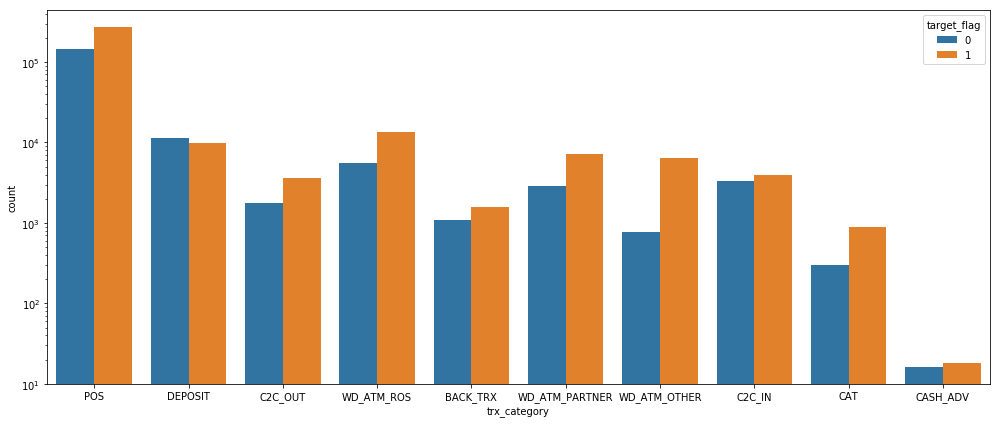

In [62]:
plt.figure(figsize = (14,6))
ax = sns.countplot(x = 'trx_category', hue='target_flag', data=df)
ax.figure.get_axes()[0].set_yscale('log')
plt.tight_layout()

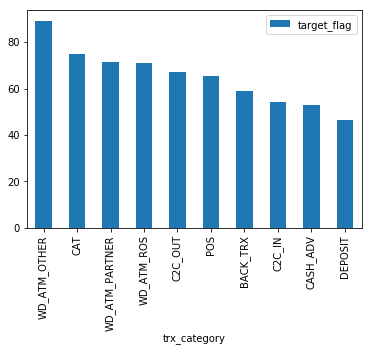

In [25]:
trx_category = (df[['trx_category', 'target_flag']].groupby('trx_category').sum()
 /
df[['trx_category', 'target_flag']].groupby('trx_category').count())*100

trx_category.sort_values('target_flag', ascending=False).plot(kind='bar')
# Доля оставшихся клиентов для разных категорий транзаций

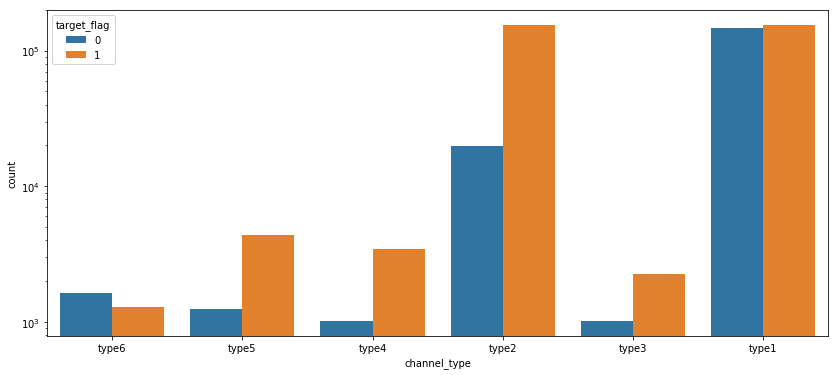

In [122]:
plt.figure(figsize = (14,6))
ax = sns.countplot(x = 'channel_type', hue='target_flag', data=df)
ax.figure.get_axes()[0].set_yscale('log')

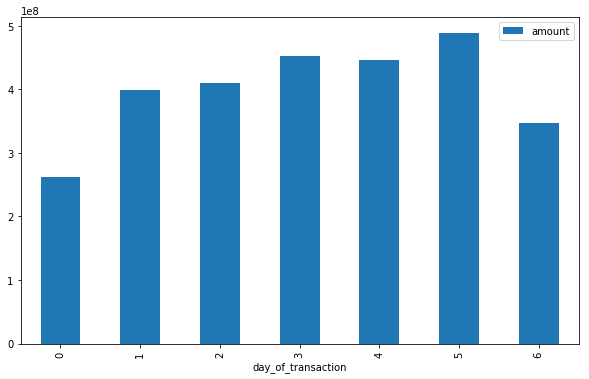

In [117]:
# сумма трат по дням недели
df[['day_of_transaction', 'amount']].groupby('day_of_transaction').sum().plot(kind='bar', figsize=(10,6))